# TANG HAN KANG U2022842C

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [1]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler

In [2]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

# Read Data

In [3]:
df = pd.read_csv('./full.csv') 
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966


In [4]:
df['label'] = df['filename'].str.split('_').str[-2] #take the pos/neg label of the filename

In [5]:
df['label'].value_counts() #no. of occurence for each label

pos    92826
neg    89428
Name: label, dtype: int64

Split and scale dataset

In [85]:

columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder() 

  df['label'] = label_encoder.fit_transform(df['label']) #Encode target labels with value between 0 and n_classes-1.

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1) #take only one inputs
  y_train2 = df_train['label'].to_numpy() #take only the outputs

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler() #Standardize features by removing the mean and scaling to unit variance
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

# Question 1: Part A

## Model requirements
feedforward deep neural network (DNN),  input layer, three hidden
layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid
activation function. Use a mini-batch gradient descent with ‘adam’ optimizer with learning rate of
0.001, and batch size = 256. Apply dropout of probability 0.2 to each of the hidden layers.

## Create model

In [7]:
model = Sequential([
    Dense(128, activation='relu'),
    Dropout(rate=0.2),
    Dense(128, activation='relu'),
    Dropout(rate=0.2),
    Dense(128, activation='relu'),
    Dropout(rate=0.2),
    Dense(1, activation='sigmoid')
]) #2 categories in output layer

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Set Learning Params

In [8]:
num_epochs = 100
batch_size = 256

## Train Model

In [9]:
history = model.fit(X_train_scaled, y_train,
    epochs=num_epochs,
    batch_size = batch_size,
    verbose=0,
    callbacks = [callback],
    use_multiprocessing=True,
    validation_data=(X_test_scaled, y_test))

# Question: 1 Part B

## Plot learning curves

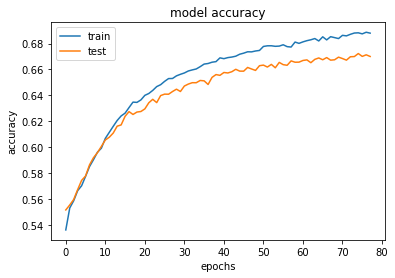

In [10]:
#plot for model accuracy
plt.figure(5)
plt.plot(history.history['accuracy']) #train
plt.plot(history.history['val_accuracy']) #test, validation data
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

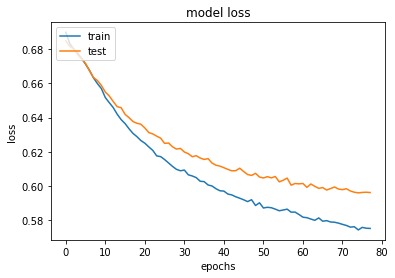

In [11]:
#plot for model loss
plt.figure(5)
plt.plot(history.history['loss']) #train
plt.plot(history.history['val_loss']) #test, validation data
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Explain the use of early stopping in this question?

For training neural networks, an important hyper parameter to tune is the number of epochs. Too many or too few epochs leads to over fitting and underfitting respectively. Early stopping supposedly allows user to state a random large number of training epochs, but training stops once model performance stops improving. For this question, although the stated number of epochs is 100, the model stopped training when epoch count reaches 60. This meant that at epoch 60, there's no substantial change in model's losses. Hence, training is stopped to prevent overfitting.

# Question 2: Part A

## callback class definition

In [15]:
class Timecallback(tf.keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.times = []
        
    #def on_train_begin(self, logs={}):
        #self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

## KFold() cross validation

In [20]:
batch_sizes = [128, 256, 512, 1024]
X_train, y_train #5-fold xvalid on X_train only

def train(batchSize):
    model = Sequential([
        Dense(128, activation='relu'),
        Dropout(rate=0.2),
        Dense(128, activation='relu'),
        Dropout(rate=0.2),
        Dense(128, activation='relu'),
        Dropout(rate=0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) 
    timecallback = Timecallback()
    folds = 5
    kf = KFold(n_splits=folds)
    #losses=[]
    accuracies=[]
    lastEpochTimes=[] 

    #only working with training partition
    for trainIndex, testIndex in kf.split(X_train):#testIndex are the indexes of the test cases in training partition for a particular split
        kf_X_train_scaled, kf_X_test_scaled = preprocess_dataset(X_train.iloc[trainIndex], X_train.iloc[testIndex]) #scaled based on splits
        history = model.fit(kf_X_train_scaled, y_train[trainIndex],
                            epochs=100,
                            batch_size = batchSize,
                            verbose=0,
                            callbacks = [callback, timecallback],
                            use_multiprocessing=True,
                            validation_data=(kf_X_test_scaled, y_train[testIndex]))
        #losses.append(history.history['val_loss']) #loss of final epoch
        accuracies.append(history.history['val_accuracy'].pop()) # accuracy of final of last epoch
        #each split will have one final epoch accuracy
        lastEpochTimes.append(timecallback.times.pop()) #last epoch
    return [
        #np.mean(np.array(losses), axis=0), 
        np.mean(np.array(accuracies), axis=0),
        np.mean(np.array(lastEpochTimes), axis=0) #do we return the median, check with prof
    ]

In [21]:
import warnings
warnings.filterwarnings('ignore')

#arr_losses=[]
arr_accuracies=[]
arr_LEtimes=[] 

for batch in batch_sizes:
    accuracy, lastEpochTime = train(batch)
    #arr_losses.append(loss)
    arr_accuracies.append(accuracy)
    arr_LEtimes.append(lastEpochTime)

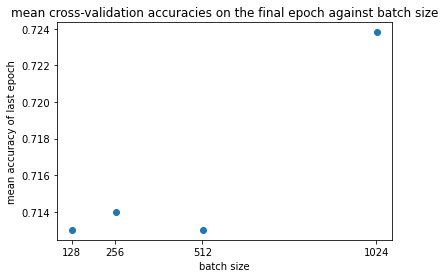

In [40]:
plt.scatter(y=arr_accuracies, x=batch_sizes)
plt.title('mean cross-validation accuracies on the final epoch against batch size')
plt.ylabel('mean accuracy of last epoch')
plt.xlabel('batch size')
plt.xticks(ticks=[127,255,511,1023], labels = ['128', '256', '512', '1024'])
plt.show()

# Question 2: Part B

## Create table comparing last epoch time of each batch size

In [24]:
LEtimesDF = pd.DataFrame(data={
    'Batch sizes': batch_sizes,
    'Last Epoch time': arr_LEtimes
})

LEtimesDF

,Batch sizes,Last Epoch time
0,128,2.840483
1,256,1.805780
2,512,1.133074
3,1024,1.407199


# Question 2: Part C

## Select optimal batch size

From the results of 5-fold cross validation performed in Q2A, I choose 1024 as the optimal batch size. Batch size = 1024 gave me the best accuracy with a reasonable training time (Last Epoch Eime).

# Question 2: Part D

## What happens when batch size is increase? Why?

As evident from the last epoch time array, as batch size increase, it takes a shorter time to train the model. This is because with larger batch size, we can take advantage of the parallelism of GPUs which allows for computational speedups. However, it is also to be noted that a larger batch size leads to a drop in accuracy and increase in loss. Currently, there's no widely accepted reason as to why this is the case. This observation can be vaguely attributed to the concept of overfitting. With larger batch size, there is less "noise" introduced during batch size training as compared to smaller batch size. Hence, the network will be more prone to overfitting on the training set, which causes it to perform badly on the test set.

# Question 2: Part E

## Validate model with test set using optimal batch size

In [33]:
optBatchSize = 1024
history = model.fit(X_train_scaled, y_train,
    epochs=num_epochs,
    batch_size = optBatchSize,
    verbose=1,
    callbacks = [callback],
    use_multiprocessing=True,
    validation_data=(X_test_scaled, y_test))

Epoch 1/100
125/125 [==============================] - 1s 10ms/step - loss: 0.5577 - accuracy: 0.7038 - val_loss: 0.5877 - val_accuracy: 0.6776
Epoch 2/100
125/125 [==============================] - 1s 10ms/step - loss: 0.5584 - accuracy: 0.7011 - val_loss: 0.5872 - val_accuracy: 0.6779
Epoch 3/100
125/125 [==============================] - 1s 10ms/step - loss: 0.5573 - accuracy: 0.7041 - val_loss: 0.5866 - val_accuracy: 0.6784
Epoch 4/100
125/125 [==============================] - 1s 10ms/step - loss: 0.5559 - accuracy: 0.7036 - val_loss: 0.5870 - val_accuracy: 0.6786
Epoch 5/100
125/125 [==============================] - 1s 10ms/step - loss: 0.5570 - accuracy: 0.7038 - val_loss: 0.5861 - val_accuracy: 0.6789
Epoch 6/100
125/125 [==============================] - 1s 10ms/step - loss: 0.5556 - accuracy: 0.7045 - val_loss: 0.5859 - val_accuracy: 0.6789
Epoch 7/100
125/125 [==============================] - 1s 10ms/step - loss: 0.5558 - accuracy: 0.7049 - val_loss: 0.5870 - val_accuracy:

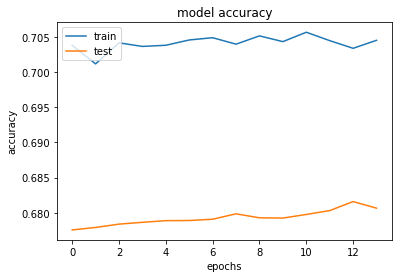

In [34]:
#line plots for accuracy and loss
#plot for model accuracy
plt.figure()
plt.plot(history.history['accuracy']) #train
plt.plot(history.history['val_accuracy']) #test, validation data
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Question 3: Part A

## Define helper function

In [41]:
numNeurons = [64, 128, 256]

def neuronTrain(numNeuron):
    model = Sequential([
        Dense(numNeuron, activation='relu'),
        Dropout(rate=0.2),
        Dense(numNeuron, activation='relu'),
        Dropout(rate=0.2),
        Dense(numNeuron, activation='relu'),
        Dropout(rate=0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    folds = 5
    kf = KFold(n_splits=folds)
    accuracies=[]

    #only working with training partition
    for trainIndex, testIndex in kf.split(X_train):#testIndex are the indexes of the test cases in training partition for a particular split
        kf_X_train_scaled, kf_X_test_scaled = preprocess_dataset(X_train.iloc[trainIndex], X_train.iloc[testIndex]) #scaled based on splits
        history = model.fit(kf_X_train_scaled, y_train[trainIndex],
                            epochs=100,
                            batch_size = optBatchSize,
                            verbose=0,
                            callbacks = [callback],
                            use_multiprocessing=True,
                            validation_data=(kf_X_test_scaled, y_train[testIndex]))
        accuracies.append(history.history['val_accuracy'].pop()) # accuracy of last epoch for each fold
    return np.mean(accuracies)

## Run the cross validation

In [42]:
arr_accuracies = []
for numNeuron in numNeurons:
    accuracy = neuronTrain(numNeuron)
    arr_accuracies.append(accuracy)

## Scatterplot of last epoch accuracy and num of neurons

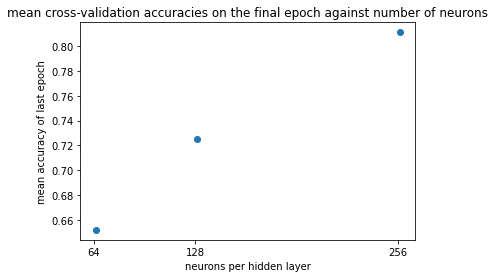

In [44]:
plt.scatter(y=arr_accuracies, x=numNeurons)
plt.title('mean cross-validation accuracies on the final epoch against number of neurons')
plt.ylabel('mean accuracy of last epoch')
plt.xlabel('neurons per hidden layer')
plt.xticks(ticks=[63,127,255], labels = numNeurons)
plt.show()

# Question 3: Part B

## Choosing optimal number of neurons for hidden layers

Optimal number of neurons per hidden layer = 256 since it gives the highest mean accuracy for the last epoch.

# Question 3: Part C

## Train model with optimal number of neurons in each hidden layer

In [191]:
optNumNeuron = 256
model = Sequential([
        Dense(optNumNeuron, activation='relu'),
        Dropout(rate=0.2),
        Dense(optNumNeuron, activation='relu'),
        Dropout(rate=0.2),
        Dense(optNumNeuron, activation='relu'),
        Dropout(rate=0.2),
        Dense(1, activation='sigmoid')
    ])
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train,
    epochs=num_epochs,
    batch_size = optBatchSize,
    verbose=0,
    callbacks = [callback],
    use_multiprocessing=True,
    validation_data=(X_test_scaled, y_test))

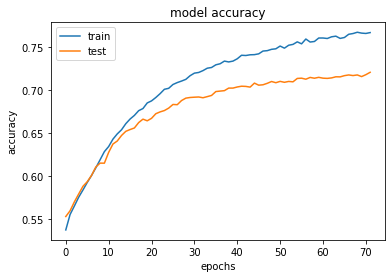

In [192]:
#line plots for accuracy and loss
#plot for model accuracy
plt.figure()
plt.plot(history.history['accuracy']) #train
plt.plot(history.history['val_accuracy']) #test, validation data
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Question 3: Part D

## Dropouts

By applying dropouts, during each step of training, there's a probability that some number of a layer ouput are ignored/set to 0. This is to prevent overfitting by stopping the network from relying too much on single neurons, which in turn forces all neurons to generalize better.

# Question 3: Part E

## Adding weight regularization for model declaration

Weight regularizations forces the trained model to be simpler, by contraining the weights to only take small values. This in turn regularizes the weight distribution. A simpler model is less likely to overfit compared to complex ones. The chosen method for weight regularization is the in-built L1 and L2 regularizations of the tensorflow library.

In [84]:
model_E = Sequential([
        Dense(optNumNeuron, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(rate=0.2),
        Dense(optNumNeuron, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(rate=0.2),
        Dense(optNumNeuron, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(rate=0.2),
        Dense(1, activation='sigmoid')
    ])
model_E.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
history = model_E.fit(X_train_scaled, y_train,
    epochs=num_epochs,
    batch_size = optBatchSize,
    verbose=0,
    callbacks = [callback],
    use_multiprocessing=True,
    validation_data=(X_test_scaled, y_test))

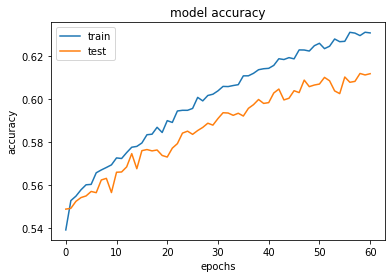

In [49]:
#line plots for accuracy and loss
#plot for model accuracy
plt.figure(1)
plt.plot(history.history['accuracy']) #train
plt.plot(history.history['val_accuracy']) #test, validation data
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

From the above plot, it can be observed that both the validation accuracy and train accuracy have fallen compared to the results from question 3 part c. However, accuracy can be improved by tuning the regularizer's hyperparameter.

# Question 4: Part A

In [198]:
record_df = pd.read_csv('./new_record.csv') #recorded audio after preprocessing

## Redefine helper functions

In [199]:
record_df

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,record.wav,112.347147,640,91.428571,0.498265,0.096295,0.355535,0.109088,0.227224,0.031703,...,-2.498537,115.060074,-13.967159,202.26158,1.358878,92.402275,-11.671063,147.37758,-5.26199,77.15312


## Scale X_test

In [209]:
X_test_record = record_df.drop(['filename'], axis = 1) #since the filename is not labelled with any label, theres no need to encode label
X_train_scaled_record, X_test_scaled_record = preprocess_dataset(X_train, X_test_record) #only concern with the scaled X_test

# Question 4: Part B

## Use trained model from Q3C) to predict polarity

In [210]:
predicted_value = model.predict(X_test_scaled_record)

1/1 [==============================] - 0s 16ms/step


In [211]:
print("The model's output value for the recorded wav file is", predicted_value.flatten())

The model's output value for the recorded wav file is [0.76286036]


Using a threshold of 0.5, the predicted label for the recorded audio is positive (pos).

# Question 4: Part C

## import libraries

In [204]:
import shap

shap.initjs()

## Calculating SHAP values

In [216]:
# select backgroud for shap, contains a random selection of 1000 inputs
background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 1000, replace=False)]

#conver to tensor
#background=tf.convert_to_tensor(background) 

In [217]:
#use DeepExplainer to explain predictions of the model
deep_binary_explainer = shap.DeepExplainer(model, background)

array([[ 0.22756814, -0.39789238, -0.34077142, ..., -0.30259113,
         0.34038978, -0.1155764 ],
       [-1.15528725, -0.68759841, -0.89842659, ..., -0.50387247,
        -0.52524927, -0.71683298],
       [ 1.52661411,  1.33323444,  0.97480424, ...,  2.86035908,
        -0.13025909,  1.8605468 ],
       ...,
       [-1.3771357 , -0.34152539,  0.14530567, ..., -0.59152151,
         0.71307112, -0.81739874],
       [ 0.66058346,  1.74049865,  1.5735335 , ..., -0.35203884,
         0.71662613, -0.56892213],
       [-0.78280095, -0.2097485 ,  0.14887928, ..., -0.28752624,
        -0.40325442, -0.23697954]])>]. Consider rewriting this model with the Functional API.


In [218]:
x_test_dict = dict()
for i, l in enumerate(y_test):
    if len(x_test_dict) == 10: break
    if l not in x_test_dict.keys():
        x_test_dict[l] = X_test_scaled[i]

In [219]:
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
#convert to tensor
x_test_each_class = np.asarray(x_test_each_class)

In [220]:
shap_values=deep_binary_explainer.shap_values(x_test_each_class)

array([[-0.2807542 , -0.71628972, -1.00837464,  0.58561557, -0.59505307,
        -0.22962604, -0.48601334, -0.42741458,  0.45526591, -0.31398887,
        -0.28151223,  0.80419228,  0.01040147, -1.58302335,  0.27481641,
        -0.0660952 , -0.43668066, -0.43025276, -0.1802666 , -0.09847372,
        -0.3020963 , -0.76679347, -0.68624352, -0.04039677, -0.04039677,
         0.13243254,  0.13243254,  0.65873149, -0.32746058, -0.47817077,
        -0.55059817, -0.01692945, -0.27713988,  0.18669704, -0.34267586,
        -0.5691834 , -0.25585721,  0.16671673,  0.59496187,  0.92656278,
        -0.14112169,  0.08656895,  0.0109908 ,  1.98638733,  1.87847313,
        -0.44861345,  1.21273597,  0.25612867,  0.53463707,  1.9374933 ,
         0.65257422, -0.48113004,  1.09624109,  0.18284458, -0.25376285,
        -0.25242409,  0.20245416, -0.69311499,  1.448128  ,  0.78708256,
        -0.28201522, -0.10640908,  0.590462  ,  0.77110956, -0.34619024,
         0.64811419, -0.82466296, -0.22532677, -0.5

In [222]:
shap.force_plot(deep_binary_explainer.expected_value[0].numpy(), shap_values[0][0], 
                features = record_df.drop(['filename'], axis=1).columns)

## Observations

mfcc11_mean is the most influential in pushing the base value higher, whereas mfcc3_var is the most influential in pushing the base value lower.

# Conclusion

To summarise my findings for this experiment, after applying 5-fold cross validation, the optimal batch size is 1024 and the optimal number of neurons per hidden layer is 256. SHAP’s force plot provided a overview of the relative importance of each feature with respect to label prediction. I identified ______ as the most important feature.

In my opinion, the way someone expresses positivity and negativity in their speech differs from person to person. Examples of factors that may affect soundwaves are: gender, age group, race, presence of an accent. Certain individual may also have speech impediment, even the present of braces or dentures can affect the soundwaves. For the same class of speech polarity, there may be countless combination of inputs, with large range for each of the features in the input. Also, given that the factors mentioned above are not accounted for in the data set, it is very difficult for the model to learn a good enough allocation of weights and biases that transforms the inputs into its correct label. 

Comparing batch size and number of neurons, I believe number of neurons was more impactful in improving the model performance. Increasing the number of neurons increases the information learnt by the model. To simplify the understanding of the black box of the trained neural network, imagine the neural network attempting to piece back sound waves based on the input feature values. With more neurons, the model is able to piece back a clearer soundwaves as compared to if  only 2 neurons are used (one for amplitude and one for period etc.).

Besides FFN, I may consider using recurrent neural network for modelling. Soundwaves can be said to have a sequential aspect. For example, a soundwave can be divided into segments and the order of these segments may provide additional information for the model. Recurrent neural network can pick up information about the sequencing of the segmented soundwaves, an aspect where FFN falls short. To implement recurrent neural network, model should allow the connections between neurons to form cycles. 

Another application for modelling of waveform data, is the study of seismic waveform.  Ideally the model can be used to accurately calculate the magnitude of an earthquake, or the level of damage done to a certain area because of the earthquake. To perform this task, I need to change how the data is pre-processed and increase the number of label classes. I can also consider adding other dataset that provides information on the infrastructure/population in affected areas. Since I am placing a higher emphasis on accuracy, I will tune more parameters like number of hidden layers, learning rate etc. 
